In [521]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db = dm.read_db(base='prices_global.pkl', add='prices_global_gwx.pkl')
db_kr = dm.read_db(base='prices_kr.pkl', add='prices_global.pkl')

In [379]:
base_params = {
    'start': '2002-12-31', 
    'end': '2018-08-31', #'2018-03-31', 
    'db': db, 
    'assets': setting.assets_global_eq, 
    'price': {'price_src':'reprice', 'trade_tol':'at_close'}, 
    'trade': {
        'trade_assets': [
            #('BND_US_Long', {'BND_US_Interm':0.3, 'BND_US_Short':0.1}), 
            #('BND_US_Long', {'BND_US_Long':1.0}), 
        ], 
        'trade_prev_nav_based': True, 
        'trade_delay': 1, 
        'freq': 'M', 
        'cash': 100000000, 
        'expense': 0.001, 
        'gr_exposure': 0.99, }, 
    'selecting': {
        'mode': 'DualMomentum', #'DualMomentum', 'AbsoluteMomentum', 'RelativeMomentum'
        'sig_mixer': {
            'sig_w_base': [1,0,0,0,0,0,1,0,0,0,0,0], #[1,0,0,0,0,0,1,0,0,0.25*4,0.25*6,0.25*12]
            'sig_w_term': 21, 
            'sig_w_dynamic': True, 
            'sig_dyn_fwd': 21*np.array([1]), 
            'sig_dyn_m_backs': 24, 
            'sig_dyn_n_sample': 63, 
            'sig_dyn_thres': 0.0, }, 
        'market': 'ACWI', # None도 가능
        'supporter': 'BND_US_Long', 
        'cash_equiv': 'BND_US_AGG', 
        #'overwrite_to_bet': [], # base_params flattening 하므로, 반드시 list of tuple로 입력
        'n_picks': 10, }, 
    'weighting': {
        'w_type': 'ranky2', 
        'eaa_wr': 1.0, 
        'eaa_wc': 1.0, 
        'eaa_wr_bnd': 0.5, 
        'eaa_short_period': 20, 
        'iv_period': 60, 
        'w_max': 1.0, }, 
    'stats_opts': {
        'beta_to': 'ACWI', 
        'stats_n_roll': 250, }, 
    'reinforce': {
        'follow_trend': (20,60), 
        'follow_trend_market': (20, 60),
        'follow_trend_supporter': (20, 60), 
        'strong_condition': True, }, 
    'te_control': {
        'bm': None, #'ACWI', 
        'te_target': None, 
        'te_k': 0.3, 
        'te_short_period': 20, 
        'te_short_up_down_ratio_cap': True, 
        'te_short_target_cap': True, 
        'te_smoother': False, 
        'safety_buffer': 0.8, }, 
    'cash_manager': {
        'cm_method': None, #'cp', 
        'up_down_ratio_period': 20, 
        'kelly_type': 'semivariance', 
        'kelly_vol_period': 250, 
        'kelly_self_eval': True, }
}

In [528]:
region = q.Backtester(base_params, w_type='ew', n_picks=5, assets=setting.assets_multiasset, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, 
    market='ACWI', 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    start='2002-12-31', 
)


2.7611825466156006


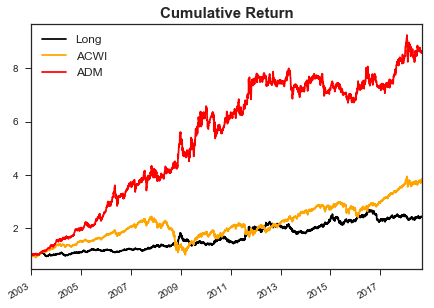

In [529]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'ADM']
color = ['k', 'orange', 'r']

region.plot_cum(strats, names=names, color=color, logy=False)

In [500]:
region.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Asia_xJp,4.82,3946,10.48,24.28,0.43,-66.87,14.88,17.84,0.76,1.06,24.10,58.82,1.09,38.88
GBP,0.93,3946,-0.47,9.55,-0.05,-41.24,0.08,8.34,0.01,0.18,49.45,50.80,0.97,-79.58
BND_US_Interm,1.89,3946,4.12,6.58,0.63,-10.40,4.68,6.07,0.73,-0.13,23.80,55.61,1.37,93.93
Comdty,1.79,3946,3.76,19.26,0.20,-74.02,4.68,18.16,0.28,0.46,39.09,52.41,1.15,-136.35
DualMomentum,8.37,3946,14.41,14.72,0.98,-20.71,13.23,13.19,0.94,0.17,12.63,63.10,1.39,82.88


In [375]:
adm = q.Backtester(base_params, w_type='ew', n_picks=1, assets=setting.assets_adm, 
    sig_w_base=[0,0,0,0,0,0,1,0,0,1,0,1], 
    sig_w_dynamic=False, 
    market='ACWI', 
    #supporter='BND_US_Short', 
    follow_trend=None, 
    follow_trend_market=None, 
    follow_trend_supporter=None, 
    strong_condition=False, 
    start='2008-12-31', 
)


1.513199806213379


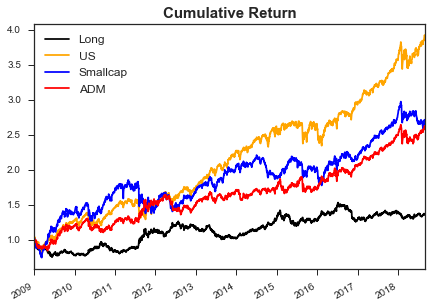

In [376]:
strats = ['BND_US_Long', 'US', 'Smallcap_xUS', 'DualMomentum']
names = ['Long', 'US', 'Smallcap', 'ADM']
color = ['k', 'orange', 'b', 'r']

adm.plot_cum(strats, names=names, color=color, logy=False)

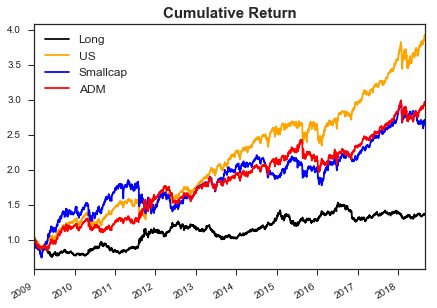

In [374]:
strats = ['BND_US_Long', 'US', 'Smallcap_xUS', 'DualMomentum']
names = ['Long', 'US', 'Smallcap', 'ADM']
color = ['k', 'orange', 'b', 'r']

adm.plot_cum(strats, names=names, color=color, logy=False)

In [291]:
#%%prun
geam = q.Backtester(base_params, w_type='inv_ranky2', start='2002-12-31', n_picks=10)


2.8702709674835205


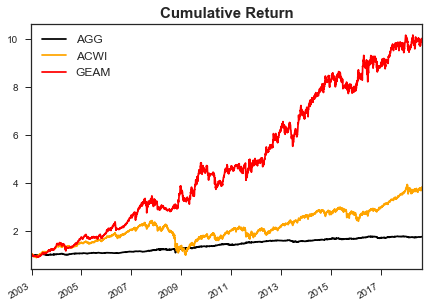

In [292]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

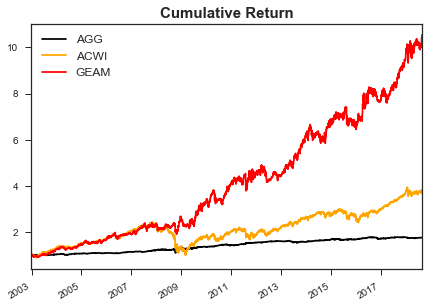

In [287]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

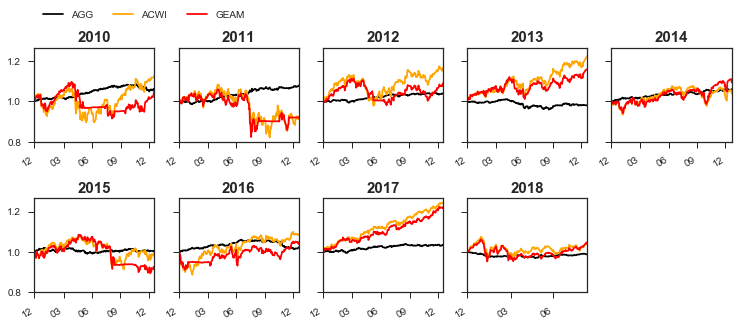

In [278]:
adm.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

In [293]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Canada,3.99,3946,9.16,21.95,0.42,-60.75,12.21,17.22,0.74,0.96,25.29,59.36,1.07,-15.27
China,8.10,3946,14.17,27.88,0.51,-73.30,14.31,22.51,0.66,0.74,25.13,60.96,1.07,33.90
Vietnam,0.73,2948,-2.64,26.65,-0.10,-69.65,-3.54,26.22,-0.14,0.51,55.21,49.64,1.07,36.41
Peru,1.84,2317,6.79,21.67,0.31,-60.62,7.19,19.54,0.37,0.82,39.46,54.13,1.14,-123.40
DualMomentum,9.93,3946,15.66,16.32,0.96,-22.79,15.02,15.36,1.02,0.24,9.76,60.43,1.47,92.78


In [288]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BDC,1.54,2815,3.92,30.05,0.13,-79.56,6.79,16.14,0.51,1.10,38.23,59.40,0.89,9.51
Homebuilder,2.37,3946,5.61,35.21,0.16,-89.63,9.27,29.15,0.36,1.20,35.68,58.82,0.91,-15.09
Semiconductor,6.23,3946,12.30,27.46,0.45,-66.85,13.75,23.50,0.56,1.07,32.49,57.75,1.15,56.09
Software,8.21,3946,14.27,22.13,0.64,-49.81,13.85,18.77,0.78,0.94,16.23,60.43,1.23,87.70
DualMomentum,10.53,3946,16.09,17.10,0.94,-20.56,16.36,14.72,1.05,0.42,6.87,63.64,1.31,98.29


In [342]:
usam = q.Backtester(
    base_params, w_type='ew', start='2002-12-31', assets=setting.assets_us_sector, n_picks=5, market='US', 
    sig_w_dynamic=False, 
    #sig_dyn_fwd=[20], 
    #sig_dyn_m_backs=6, 
    #sig_w_base=[1,0,0,1,0,1],
    sig_w_base=[0,0,0,0,0,0,1,0,0,0,0,0],
)

0.35880017280578613



2.4803998470306396


In [96]:
kfam = q.Backtester(
    base_params, w_type='ew', start='2002-12-31', assets=setting.assets_kr_factor, n_picks=5, 
    db=db_kr, 
    market='K200', supporter='KTB10Y', cash_equiv='KTB3Y', 
    follow_trend=(20,60), 
    follow_trend_market=(20,20), 
    support_cash=True, 
    sig_w_dynamic=True, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3],
)

HBox(children=(IntProgress(value=0, max=184), HTML(value='')))


4.587959289550781


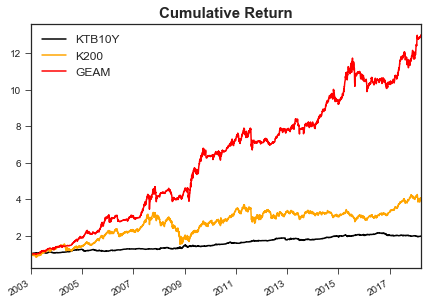

In [97]:
strats = ['KTB10Y', 'K200', 'DualMomentum']
names = ['KTB10Y', 'K200', 'GEAM']
color = ['k', 'orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

In [83]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
HighDvd_kr,8.45,3778,15.17,17.62,0.86,-50.76,14.76,15.04,1.12,0.28,16.27,64.29,1.10,72.56
LowVol_kr,8.17,3778,14.91,17.21,0.87,-43.38,13.15,15.46,0.94,0.27,18.36,59.34,1.40,64.34
ACWI,3.67,3778,8.98,19.05,0.47,-58.79,13.73,13.16,1.10,1.00,22.47,62.64,0.99,61.96
MomentumGrowth_kr,14.61,3778,19.42,23.22,0.84,-57.83,18.18,20.82,0.98,0.35,25.13,58.79,1.42,69.23
DualMomentum,9.49,3778,16.06,12.26,1.31,-32.29,15.47,10.84,1.61,0.09,8.22,67.58,1.42,83.63


In [508]:
DualMomentumSelector(['2002-12-31'], **kfam.__dict__).sig/8*100

,Contrarian_kr,DvdGrowth_kr,Value_kr,Quality_kr,Turnaround_kr,LowVol_kr,KTB3Y,K200,HighDvd_kr,HighBeta_kr,KTB10Y,Momentum_kr,MomentumGrowth_kr,Growth_kr
2002-12-31,-8.599522,NaN,-6.416362,-4.917536,NaN,-6.219984,NaN,-9.02844,-9.685044,-6.717643,NaN,NaN,-6.228624,-8.868186


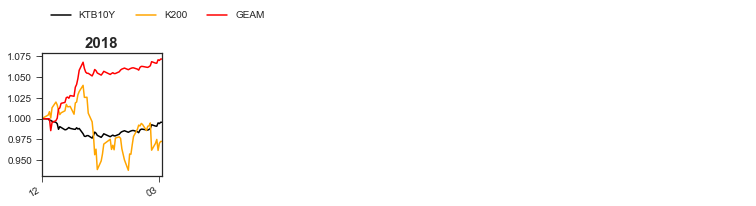

In [93]:
kfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

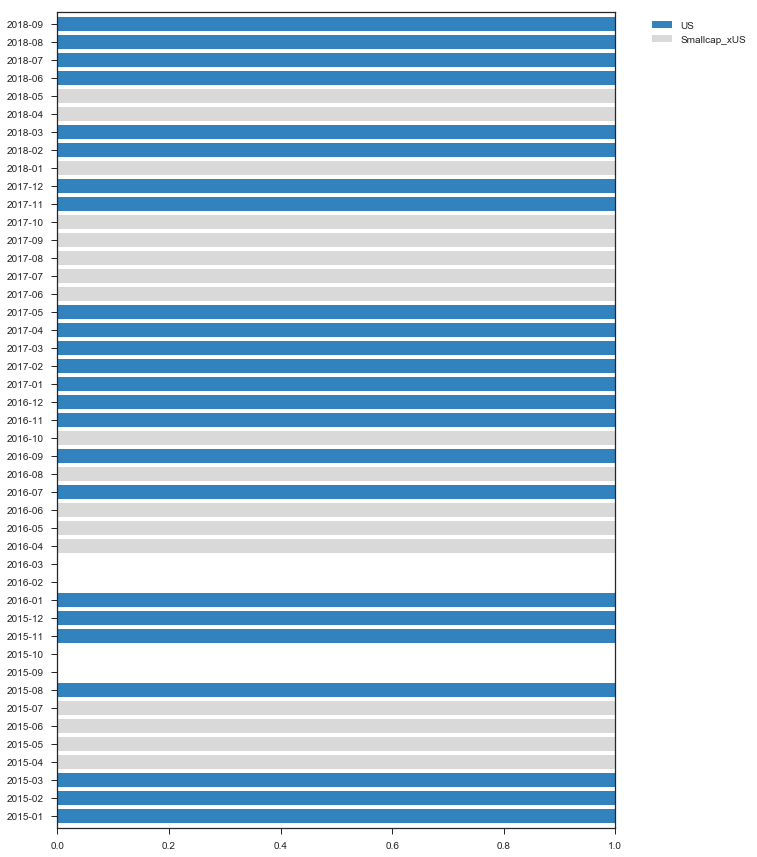

In [17]:
adm.plot_weight([2015, 2018])

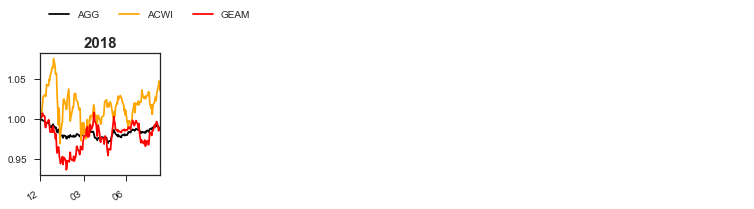

In [39]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

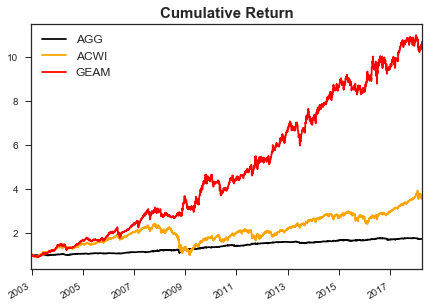

In [140]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

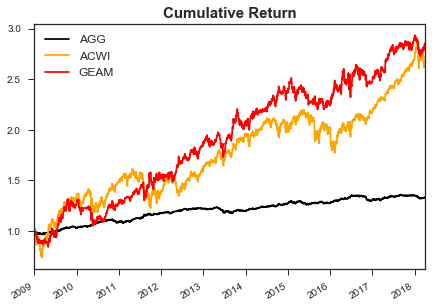

In [79]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [137]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
NewZealand,2.59,3839,6.39,12.28,0.52,-23.20,0.00,11.17,0.82,0.25,8.64,31.32,1.06,64.02
Russia,0.75,2751,-2.62,43.80,-0.06,-81.89,0.06,35.03,0.00,1.65,50.00,49.23,1.14,19.80
Chile,6.02,3839,12.40,23.04,0.54,-60.18,15.28,19.04,0.71,0.81,38.69,55.49,1.31,-45.83
Greece,0.70,1587,-5.37,43.46,-0.12,-77.39,10.20,40.40,0.25,1.65,43.57,51.35,1.04,28.94
DualMomentum,10.69,3839,16.69,15.32,1.09,-21.29,16.64,14.74,1.16,0.20,7.41,63.19,1.43,96.00


In [103]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Philip,3.79,2328,15.38,21.75,0.71,-31.77,13.39,21.95,0.65,0.54,28.19,59.09,1.30,16.66
Greece,0.70,1587,-5.37,43.46,-0.12,-77.39,10.20,40.40,0.25,1.65,43.57,51.35,1.04,28.94
HongKong,3.21,2328,13.36,19.93,0.67,-29.94,14.12,16.94,0.87,0.86,22.70,63.64,1.08,46.76
Netherland,2.61,2328,10.88,23.44,0.46,-33.86,10.09,19.34,0.47,1.17,27.08,60.91,1.04,76.93
DualMomentum,3.03,2328,12.65,15.52,0.82,-20.39,13.37,14.44,0.92,0.26,6.78,61.82,1.31,96.01


In [183]:
isinstance(3, float)

False

In [294]:
base_params = {
    'start': '2002-12-31', 
    'end': '2018-08-31', 
    'db': db, 
    'assets': setting.assets_fi, 
    'price': {'price_src':'reprice', 'trade_tol':'at_close'}, 
    'trade': {
        'trade_assets': [
            #('BND_US_Long', {'BND_US_Interm':0.3, 'BND_US_Short':0.2}), 
            #('BND_US_Long', {'BND_US_Long':1.0}), 
        ], 
        'trade_prev_nav_based': True, 
        'trade_delay': 1, 
        'freq': '1M', 
        'cash': 100000000, 
        'expense': 0.001, 
        'gr_exposure': 0.99, }, 
    'selecting': {
        'mode': 'DualMomentum', 
        'sig_mixer': {
            'sig_w_base': [1,0,0,0,0,0,1,0,0,1,2,3], 
            'sig_w_term': 21, 
            'sig_w_dynamic': False, 
            'sig_dyn_fwd': 21*np.array([1]), 
            'sig_dyn_m_backs': 24, 
            'sig_dyn_n_sample': 63, 
            'sig_dyn_thres': 0.0, }, 
        'market': 'BND_US_AGG', # None도 가능
        'supporter': 'BND_US_Long', 
        'cash_equiv': 'BND_US_AGG', 
        'overwrite_to_bet': [], # base_params flattening 하므로, 반드시 list of tuple로 입력
        'follow_trend': (20,60), 
        'follow_trend_market': (20, 60), 
        'n_picks': 10, }, 
    'weighting': {
        'w_type': 'ranky2', 
        'eaa_wr': 1.0, 
        'eaa_wc': 1.0, 
        'eaa_wr_bnd': 0.5, 
        'eaa_short_period': 20, 
        'iv_period': 60, 
        'w_max': 1.0, }, 
    'stats_opts': {
        'beta_to': 'ACWI', 
        'stats_n_roll': 250, }, 
    'reinforce': {
        'follow_trend_supporter': (60, 250), 
        'strong_condition': True, }, 
    'te_control': {
        'bm': None, #'ACWI', 
        'te_target': None, 
        'te_k': 0.3, 
        'te_short_period': 20, 
        'te_short_up_down_ratio_cap': True, 
        'te_short_target_cap': True, 
        'te_smoother': False, 
        'safety_buffer': 0.8, }, 
    'cash_manager': {
        'cm_method': None, #'cp', 
        'up_down_ratio_period': 20, 
        'kelly_type': 'semivariance', 
        'kelly_vol_period': 250, 
        'kelly_self_eval': True, }
}

In [295]:
gfam = q.Backtester(base_params, w_type='ranky2', n_picks=5, start='2002-12-31')


2.5114874839782715


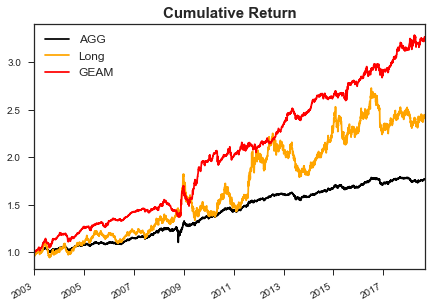

In [296]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

In [297]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_Muni,1.51,2771,3.80,5.31,0.72,-12.33,3.48,3.94,0.83,0.00,18.99,64.12,1.04,93.08
BND_DevIG_loc,1.20,2101,2.23,8.53,0.26,-17.27,2.75,8.42,0.32,0.17,32.83,55.56,1.02,12.75
BND_US_Bankloan,2.02,3946,4.57,4.13,1.11,-33.03,4.41,2.56,2.07,0.07,16.93,74.33,0.73,88.79
BND_US_Interm,1.89,3946,4.12,6.58,0.63,-10.40,4.68,6.07,0.73,-0.13,23.80,55.61,1.37,93.93
DualMomentum,3.27,3946,7.79,6.32,1.23,-12.50,6.31,5.40,1.22,0.03,3.14,65.78,1.36,97.49


In [260]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_Muni,1.51,2771,3.80,5.31,0.72,-12.33,3.48,3.94,0.83,0.00,18.99,64.12,1.04,93.08
BND_DevIG_loc,1.20,2101,2.23,8.53,0.26,-17.27,2.75,8.42,0.32,0.17,32.83,55.56,1.02,12.75
BND_US_Bankloan,2.02,3946,4.57,4.13,1.11,-33.03,4.41,2.56,2.07,0.07,16.93,74.33,0.73,88.79
BND_US_Interm,1.89,3946,4.12,6.58,0.63,-10.40,4.68,6.07,0.73,-0.13,23.80,55.61,1.37,93.93
DualMomentum,3.27,3946,7.79,6.32,1.23,-12.50,6.31,5.40,1.22,0.03,3.14,65.78,1.36,97.49


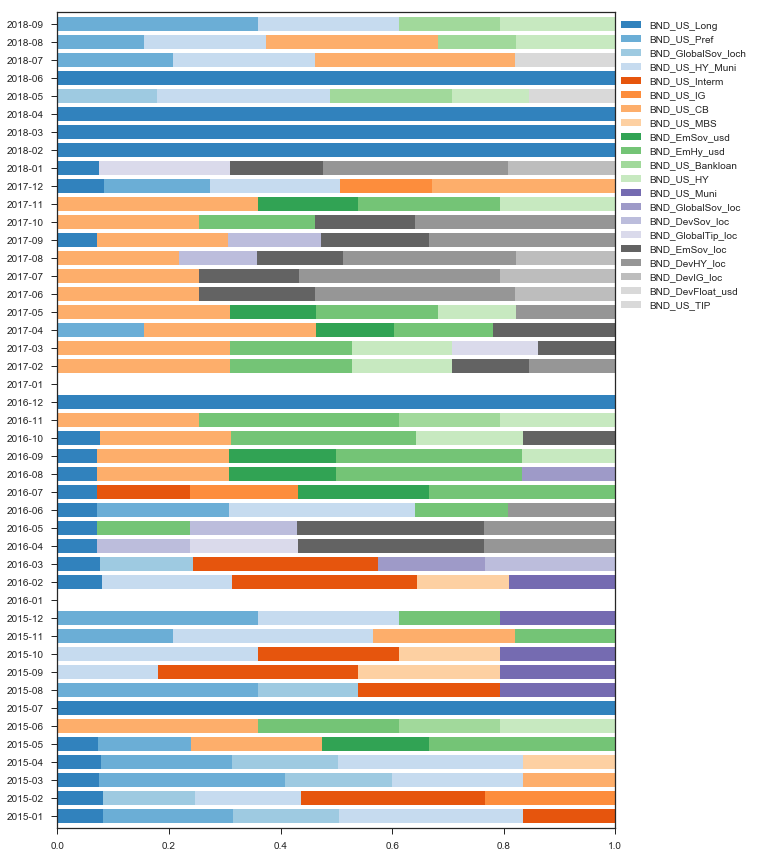

In [353]:
gfam.plot_weight([2015, 2018])

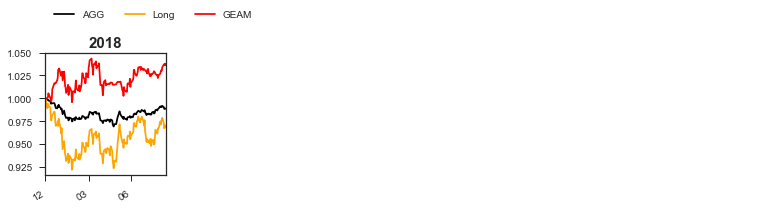

In [354]:
gfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

In [216]:
if True:
    pass
    print(1)

1
